In [ ]:
!mkdir Hurricane_Harvey
!mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

In [ ]:
!pip install segmentation-models-pytorch
!pip install torchsummary

In [8]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow
from tqdm import tqdm as progressbar
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Utils functions

In [9]:
import torch

def train_one_epoch(model, dataloader_train, dataloader_valid, optimizer, loss_function, epoch):
    #training phase
    model.train()
    train_loss = 0
    train_accuracy = 0
    for imgs, masks in tqdm(dataloader_train):
        optimizer.zero_grad()
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        # print(imgs.shape, masks.shape)
        #forward pass
        outputs = model(imgs)
        #cal loss and backward
        loss = loss_function(outputs, masks.type(torch.int64))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += pixel_accuracy(outputs, masks)
    train_loss /= len(dataloader_train)
    train_accuracy /= len(dataloader_train)
    
    #validating phase
    model.eval()
    valid_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader_valid):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(imgs)
            loss = loss_function(outputs, masks.type(torch.int64))
            valid_loss += loss.item()
            val_accuracy += pixel_accuracy(outputs, masks)
    valid_loss /=len(dataloader_valid)
    val_accuracy /= len(dataloader_valid)
    print(f'EPOCH: {epoch + 1} - train loss: {train_loss} - train_accuracy: {train_accuracy} -  valid_loss: {valid_loss} - val_accuracy: {val_accuracy}')
    return train_loss, train_accuracy, valid_loss, val_accuracy

In [10]:
import albumentations.augmentations.functional as F
from torch.utils import data
import albumentations as A
from albumentations.pytorch import ToTensorV2

class HarveyDataset(data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, _id):
        image = np.array(Image.open(self.image_paths[_id]))
        origin_mask = np.array(Image.open(self.mask_paths[_id]), dtype=np.int64)

        # print(f'Img: {os.path.basename(self.image_paths[_id])}\nMask: {os.path.basename(self.mask_paths[_id])}')

        origin_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            transformed = self.transform(image=origin_image, mask=origin_mask)
            image = transformed["image"]
            mask = transformed["mask"]
        # return origin_image, origin_mask, image, mask
        return image, mask

In [ ]:
def model_accuracy(output, target):

  # Transform the output to get the right format
  # output_softmax = F.softmax(output, dim=1)
  output_argmax = torch.argmax(output, dim=1)

  # Get the correct predictions as a boolean mask
  corrects = (output_argmax  == target)

  # Compute accuracy
  accuracy = corrects.sum().float() / float( target.size(0) * target.size(1) * target.size(2) )

  return accuracy * 100

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

### Main dataset

In [ ]:
image_paths = glob.glob('/content/Hurricane_Harvey/rasters/raw/*.tif')
mask_paths = glob.glob('/content/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks/*.png')


print(f'Len image: {len(image_paths)}, Len mask: {len(mask_paths)}')

Len image: 374, Len mask: 299


In [ ]:
temp = list(map(lambda x: os.path.basename(x)[:-3], mask_paths))

train_image_paths = list(filter(lambda x: os.path.basename(x)[:-3] in temp, image_paths))
test_image_paths = list(set(image_paths) -  set(train_image_paths))

In [ ]:
assert len(train_image_paths) == len(temp), 'Len train path should be the same to number mask'

print(f'Len train: {len(train_image_paths)}, Len test: {len(test_image_paths)}')

Len train: 299, Len test: 75


In [ ]:
train_image_paths = sorted(train_image_paths)
train_mask_paths = sorted(mask_paths)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_image_paths, train_mask_paths, test_size=0.1, random_state=42)

print(f'Number train: {len(X_train)}')
print(f'Number train: {len(X_val)}')

Number train: 269
Number train: 30


In [ ]:
train_transform = A.Compose(
    [
        A.Resize(576, 768),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        A.OneOf([
          A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
          A.Affine(translate_px={"x": (-20, 20), "y": (-20, 20)}),
          A.GaussNoise(p=0.5),
          A.Affine(scale=(0.8, 1.2)),
        ]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(576, 768),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


train_dataset = HarveyDataset(X_train, y_train, transform=train_transform)
val_dataset = HarveyDataset(X_val, y_val, transform=val_transform) 

In [ ]:
origin_image, origin_mask, image, mask = train_dataset[np.random.randint(len(y_train))]   
figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(40, 20)) 
ax[0].imshow(origin_image)
ax[1].imshow(origin_mask)
ax[2].imshow(image)
ax[3].imshow(mask)

In [ ]:
DEVICE = 'cuda'
BATCH_SIZE=2

In [ ]:
import segmentation_models_pytorch as smp
model =  smp.UnetPlusPlus(
                 encoder_name='resnet101',
                 encoder_weights='imagenet',
                #  activation='sigmoid',
                 in_channels=3,
                 classes=27,
                 encoder_depth=5, 
                 decoder_channels=[1024, 512,256,128,64]
          ).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
!ls '/content/drive/MyDrive/transfer_checkpoints/'

In [ ]:
!rm '/content/drive/MyDrive/temp1_checkpoints'/new_new_model*

In [ ]:
!rm ./checkpoints/*

In [ ]:
max_lr = 1e-3
# epoch = 50
weight_decay = 1e-4
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

max_score = 0
NUM_EPOCH = 200
hist_loss = []
for epoch in range(NUM_EPOCH): 
  print(f'=====================================Epoch: {epoch+1}')
  ret = train_one_epoch(model, train_loader, val_loader, optimizer, loss, epoch+1)
  hist_loss += [ret]
  if ret[1]+ret[3] > max_score:
    torch.save(model, f'./checkpoints/model3_{round(ret[1]*100)}_{round(ret[3]*100)}_{round(ret[2], 3)}.pt')
    max_score = ret[1] + ret[3]
    print(f'Save model: model3_{round(ret[1]*100)}_{round(ret[3]*100)}_{round(ret[2], 3)}.pt')

=====================================Epoch: 1


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 2 - train loss: 1.3520444322515417 - train_accuracy: 0.5942438911328422 -  valid_loss: 1.5634574015935263 - val_accuracy: 0.44850061118197276
Save model: model3_59_45_1.563.pt
=====================================Epoch: 2


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 3 - train loss: 1.1500527871979607 - train_accuracy: 0.6314051575491307 -  valid_loss: 1.9499447027842203 - val_accuracy: 0.4334735065901361
Save model: model3_63_43_1.95.pt
=====================================Epoch: 3


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 4 - train loss: 1.1571627886207014 - train_accuracy: 0.6274935929232804 -  valid_loss: 1.4029704729715984 - val_accuracy: 0.5670745642006804
Save model: model3_63_57_1.403.pt
=====================================Epoch: 4


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 5 - train loss: 1.060847446212062 - train_accuracy: 0.6574756855867346 -  valid_loss: 1.3428030769030253 - val_accuracy: 0.5470550329506803
Save model: model3_66_55_1.343.pt
=====================================Epoch: 5


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 6 - train loss: 1.0455265703024688 - train_accuracy: 0.6635646967120181 -  valid_loss: 1.2637380798657736 - val_accuracy: 0.6063337053571428
Save model: model3_66_61_1.264.pt
=====================================Epoch: 6


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 7 - train loss: 0.9999953473055804 - train_accuracy: 0.6717805915769084 -  valid_loss: 1.1964903235435487 - val_accuracy: 0.6203058567176871
Save model: model3_67_62_1.196.pt
=====================================Epoch: 7


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 8 - train loss: 0.9813414191758191 - train_accuracy: 0.6785084650179515 -  valid_loss: 1.2918962160746257 - val_accuracy: 0.5693990486819728
=====================================Epoch: 8


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 9 - train loss: 0.981750429338879 - train_accuracy: 0.6840677851001514 -  valid_loss: 1.4368579467137654 - val_accuracy: 0.5795333758503401
=====================================Epoch: 9


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 10 - train loss: 0.9423287367379224 - train_accuracy: 0.6928219334608844 -  valid_loss: 1.3988021731376648 - val_accuracy: 0.5796835140306124
=====================================Epoch: 10


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 11 - train loss: 0.937167783357479 - train_accuracy: 0.6957027559287606 -  valid_loss: 1.4635316769282023 - val_accuracy: 0.5753075839710885
=====================================Epoch: 11


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 12 - train loss: 0.9597406113589252 - train_accuracy: 0.6852971613992819 -  valid_loss: 1.5600915471712749 - val_accuracy: 0.6032764668367346
=====================================Epoch: 12


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 13 - train loss: 0.9182901359266705 - train_accuracy: 0.7007759353741492 -  valid_loss: 1.2507084290186563 - val_accuracy: 0.6015345982142858
Save model: model3_70_60_1.251.pt
=====================================Epoch: 13


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 14 - train loss: 0.9234616789552901 - train_accuracy: 0.7026811549272488 -  valid_loss: 1.1909503857294719 - val_accuracy: 0.6290238360969388
Save model: model3_70_63_1.191.pt
=====================================Epoch: 14


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 15 - train loss: 0.8597882526892203 - train_accuracy: 0.7183479337915725 -  valid_loss: 1.1225579301516215 - val_accuracy: 0.6464591305272107
Save model: model3_72_65_1.123.pt
=====================================Epoch: 15


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 16 - train loss: 0.8718561854627397 - train_accuracy: 0.7171880905139839 -  valid_loss: 1.2148761749267578 - val_accuracy: 0.5939373405612245
=====================================Epoch: 16


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 17 - train loss: 0.858525397821709 - train_accuracy: 0.7180734186035523 -  valid_loss: 1.1715328335762023 - val_accuracy: 0.6422552614795918
=====================================Epoch: 17


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 18 - train loss: 0.8594045133502395 - train_accuracy: 0.720793030753968 -  valid_loss: 1.2416602929433187 - val_accuracy: 0.6011532738095238
=====================================Epoch: 18


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 19 - train loss: 0.8976212757605093 - train_accuracy: 0.7101979550500753 -  valid_loss: 1.1320627331733704 - val_accuracy: 0.6515292835884353
=====================================Epoch: 19


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 20 - train loss: 0.8762694471412235 - train_accuracy: 0.7129344706632654 -  valid_loss: 1.1249041557312012 - val_accuracy: 0.6558646896258503
Save model: model3_71_66_1.125.pt
=====================================Epoch: 20


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 21 - train loss: 0.8681057344984126 - train_accuracy: 0.7219960553665911 -  valid_loss: 1.0953631718953452 - val_accuracy: 0.6515219759778912
Save model: model3_72_65_1.095.pt
=====================================Epoch: 21


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 22 - train loss: 0.8710072524017758 - train_accuracy: 0.7161323253259635 -  valid_loss: 1.213579519589742 - val_accuracy: 0.5948727147108844
=====================================Epoch: 22


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 23 - train loss: 0.8263144989808401 - train_accuracy: 0.7318636916572188 -  valid_loss: 1.1527272582054138 - val_accuracy: 0.6300801179846939
=====================================Epoch: 23


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 24 - train loss: 0.8410708080839228 - train_accuracy: 0.7281710600907025 -  valid_loss: 1.079689331849416 - val_accuracy: 0.6577268016581634
Save model: model3_73_66_1.08.pt
=====================================Epoch: 24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 25 - train loss: 0.7896066118169713 - train_accuracy: 0.7493417983512842 -  valid_loss: 1.0464221437772114 - val_accuracy: 0.6768966571003401
Save model: model3_75_68_1.046.pt
=====================================Epoch: 25


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 26 - train loss: 0.8397630656207049 - train_accuracy: 0.7313384294690101 -  valid_loss: 1.1537149707476297 - val_accuracy: 0.6311277636054421
=====================================Epoch: 26


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 27 - train loss: 0.8276197976536221 - train_accuracy: 0.7386606552343162 -  valid_loss: 1.1502941489219665 - val_accuracy: 0.6525995163690476
=====================================Epoch: 27


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 28 - train loss: 0.8175245081936872 - train_accuracy: 0.7366952770691614 -  valid_loss: 1.0511243224143982 - val_accuracy: 0.6615938562925169
=====================================Epoch: 28


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 29 - train loss: 0.8041213798302191 - train_accuracy: 0.7387987616921772 -  valid_loss: 1.0993696292241415 - val_accuracy: 0.650152131164966
=====================================Epoch: 29


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 30 - train loss: 0.8177194637280923 - train_accuracy: 0.7428605383125472 -  valid_loss: 1.106107517083486 - val_accuracy: 0.6306042729591838
=====================================Epoch: 30


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 31 - train loss: 0.7655143991664604 - train_accuracy: 0.7594509548611112 -  valid_loss: 1.1586378733317058 - val_accuracy: 0.6157691592261905
=====================================Epoch: 31


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 32 - train loss: 0.7917992627179181 - train_accuracy: 0.7467786724064626 -  valid_loss: 1.0168755531311036 - val_accuracy: 0.6742752178996599
=====================================Epoch: 32


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 33 - train loss: 0.7964808848169115 - train_accuracy: 0.7448545564058959 -  valid_loss: 1.1107924421628317 - val_accuracy: 0.6474529655612246
=====================================Epoch: 33


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 34 - train loss: 0.7472002837393019 - train_accuracy: 0.7599875106292521 -  valid_loss: 1.0537123878796895 - val_accuracy: 0.6566625478316326
=====================================Epoch: 34


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 35 - train loss: 0.7768823782602946 - train_accuracy: 0.7485795924272487 -  valid_loss: 1.0933995087941488 - val_accuracy: 0.6093411192602041
=====================================Epoch: 35


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 36 - train loss: 0.7258669932683309 - train_accuracy: 0.7617851090088816 -  valid_loss: 1.0671340068181356 - val_accuracy: 0.6729086947278912
Save model: model3_76_67_1.067.pt
=====================================Epoch: 36


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 37 - train loss: 0.7625658790270488 - train_accuracy: 0.7551495033777397 -  valid_loss: 1.0652377367019654 - val_accuracy: 0.6746904230442178
=====================================Epoch: 37


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 38 - train loss: 0.7518294219617491 - train_accuracy: 0.7596848722127739 -  valid_loss: 1.0286224246025086 - val_accuracy: 0.6669503348214286
=====================================Epoch: 38


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 39 - train loss: 0.7432319793436263 - train_accuracy: 0.7627167186318974 -  valid_loss: 1.0607115745544433 - val_accuracy: 0.6632168101615646
=====================================Epoch: 39


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 40 - train loss: 0.7749193734592862 - train_accuracy: 0.7576932161753595 -  valid_loss: 1.0103280027707418 - val_accuracy: 0.6738008875425171
=====================================Epoch: 40


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 41 - train loss: 0.7031308977692216 - train_accuracy: 0.7743260021022301 -  valid_loss: 1.1408243417739867 - val_accuracy: 0.6369426286139456
=====================================Epoch: 41


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 42 - train loss: 0.7452454134269997 - train_accuracy: 0.7625907177106951 -  valid_loss: 1.0750894705454508 - val_accuracy: 0.6656017485119047
=====================================Epoch: 42


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 43 - train loss: 0.7097052803745976 - train_accuracy: 0.7734343259873394 -  valid_loss: 1.0170134743054708 - val_accuracy: 0.6810653167517007
Save model: model3_77_68_1.017.pt
=====================================Epoch: 43


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 44 - train loss: 0.746171134489554 - train_accuracy: 0.7607512666524942 -  valid_loss: 0.9886626799901327 - val_accuracy: 0.6745608790391154
=====================================Epoch: 44


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 45 - train loss: 0.7457671324412029 - train_accuracy: 0.7596967563066885 -  valid_loss: 1.1398545304934184 - val_accuracy: 0.6237969015731293
=====================================Epoch: 45


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 46 - train loss: 0.7534306112262937 - train_accuracy: 0.7574891935941042 -  valid_loss: 1.0099401195844016 - val_accuracy: 0.6758955144557822
=====================================Epoch: 46


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 47 - train loss: 0.758753709881394 - train_accuracy: 0.7557292404809145 -  valid_loss: 1.0755901336669922 - val_accuracy: 0.6503627232142857
=====================================Epoch: 47


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 48 - train loss: 0.7094030912275667 - train_accuracy: 0.7654347068688587 -  valid_loss: 1.026219383875529 - val_accuracy: 0.6747794430272108
=====================================Epoch: 48


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 49 - train loss: 0.7327262198483503 - train_accuracy: 0.7660686236300077 -  valid_loss: 1.060267980893453 - val_accuracy: 0.6768275669642858
=====================================Epoch: 49


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 50 - train loss: 0.725569490481306 - train_accuracy: 0.7675741390306126 -  valid_loss: 0.9783972382545472 - val_accuracy: 0.6808693399234695
=====================================Epoch: 50


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 51 - train loss: 0.7164286898242103 - train_accuracy: 0.7731807740457297 -  valid_loss: 1.0072412967681885 - val_accuracy: 0.692559523809524
Save model: model3_77_69_1.007.pt
=====================================Epoch: 51


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 52 - train loss: 0.7157501066172565 - train_accuracy: 0.7760494171626985 -  valid_loss: 0.9626761595408122 - val_accuracy: 0.6997674851190477
Save model: model3_78_70_0.963.pt
=====================================Epoch: 52


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 53 - train loss: 0.7245959370224564 - train_accuracy: 0.764931293698035 -  valid_loss: 0.9647252837816874 - val_accuracy: 0.6950999149659863
=====================================Epoch: 53


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 54 - train loss: 0.6839941523693226 - train_accuracy: 0.7798408121929326 -  valid_loss: 0.9743967771530151 - val_accuracy: 0.7061058407738094
Save model: model3_78_71_0.974.pt
=====================================Epoch: 54


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 55 - train loss: 0.6537095372323637 - train_accuracy: 0.7886500259826151 -  valid_loss: 1.0190442164738973 - val_accuracy: 0.6796124309098637
=====================================Epoch: 55


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 56 - train loss: 0.7085316574132001 - train_accuracy: 0.7766403002173092 -  valid_loss: 0.9389251311620076 - val_accuracy: 0.70974503082483
Save model: model3_78_71_0.939.pt
=====================================Epoch: 56


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 57 - train loss: 0.6759838243325551 - train_accuracy: 0.7822889355394937 -  valid_loss: 0.971250836054484 - val_accuracy: 0.6920818718112245
=====================================Epoch: 57


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 58 - train loss: 0.6635873100271932 - train_accuracy: 0.7840012046485263 -  valid_loss: 0.9773884812990824 - val_accuracy: 0.6860710299744899
=====================================Epoch: 58


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 59 - train loss: 0.7135524504714542 - train_accuracy: 0.7746563208616781 -  valid_loss: 0.9875717997550965 - val_accuracy: 0.6873691273384352
=====================================Epoch: 59


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 60 - train loss: 0.7106278980219806 - train_accuracy: 0.7687812234268704 -  valid_loss: 1.0076058586438497 - val_accuracy: 0.6719035661139454
=====================================Epoch: 60


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 61 - train loss: 0.6910890323144419 - train_accuracy: 0.7776350210222978 -  valid_loss: 0.9351808329423269 - val_accuracy: 0.7003527582908163
=====================================Epoch: 61


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 62 - train loss: 0.7325609800992189 - train_accuracy: 0.7661100334230916 -  valid_loss: 0.984129806359609 - val_accuracy: 0.6974848533163265
=====================================Epoch: 62


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 63 - train loss: 0.6331936970905021 - train_accuracy: 0.7973652742346938 -  valid_loss: 1.006977637608846 - val_accuracy: 0.6864596619897959
=====================================Epoch: 63


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 64 - train loss: 0.6970374558810835 - train_accuracy: 0.7735680774045728 -  valid_loss: 0.9639334758122762 - val_accuracy: 0.7058421024659864
=====================================Epoch: 64


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 65 - train loss: 0.6353245852170167 - train_accuracy: 0.7950201955782317 -  valid_loss: 0.9191917777061462 - val_accuracy: 0.7180497980442176
Save model: model3_80_72_0.919.pt
=====================================Epoch: 65


  0%|          | 0/135 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-5f483b0508b8>", line 12, in <module>
    ret = train_one_epoch(model, train_loader, val_loader, optimizer, loss, epoch+1)
  File "<ipython-input-48-cb2f581921e6>", line 41, in train_one_epoch
    for imgs, masks in tqdm(dataloader_train):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 259, in __iter__
    for obj in it:
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1316, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/uti

KeyboardInterrupt: ignored

<ipython-input-50-14270efc24c4>:16: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'TiffImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  image = np.array(Image.open(self.image_paths[_id]))


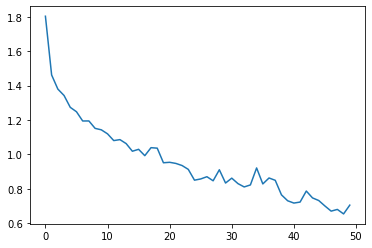

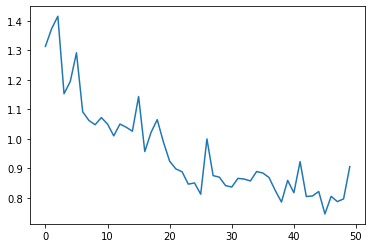

In [ ]:
train_losses = []
val_losses = []
for _train_loss, _val_loss in hist_loss:
  train_losses += [_train_loss]
  val_losses += [_val_loss]

plt.plot(train_losses)
plt.show()
plt.plot(val_losses)
plt.show()

### Syn dataset

#### Gen data

In [12]:
!mkdir Hurricane_Harvey_Synthetic 
!mkdir Hurricane_Harvey_Synthetic/rasters Hurricane_Harvey_Synthetic/vectors 
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav-synthetic/rasters/raw Hurricane_Harvey_Synthetic/rasters/ 
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/ Hurricane_Harvey_Synthetic/vectors/

Streaming output truncated to the last 5000 lines.
Copying gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/63777cf63ef4b4b98afc8025.json...
Copying gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/63777cf63ef4b4b98afc8026.json...
Copying gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/63777cf63ef4b4b98afc8027.json...
Copying gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/63777cf63ef4b4b98afc8028.json...
Copying gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/63777cf63ef4b4b98afc8029.json...
Copying gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/63777cf63ef4b4b98afc802a.json...
Copying gs://geoengine-dataset-houston-uav-synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/63777cf63ef4b4b98afc802b.json...
Copying gs://geoengine-da

In [13]:
# create the masks from the json document
import json
import numpy as np
import os
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

def create_masks(json_folder, output_folder):
    class_colormap = {}
    for json_file in tqdm(os.listdir(json_folder)):
        with open(json_folder + json_file) as f:
            data = json.load(f)
        try:
          image_width = data["images"][0]["width"]
          image_height = data["images"][0]["height"]
          image_name = data["images"][0]["name"]
          # print(f"image_name {image_name}")
          if f'{image_name}.png' in os.listdir(output_folder):
            print("\t image alredy saved")
            continue
          mask = Image.new('L', (image_width, image_height))
          for annotation in data["annotations"]:
              segmentation = annotation["segmentation"][0]
              segmentation = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation) - 2, 2)]
              label = annotation["properties"][0]["labels"][0]
              # check if this label has been seen before
              if label not in class_colormap:
                  # choose a new grayscale value for this label
                  class_colormap[label] = len(class_colormap)
              ImageDraw.Draw(mask).polygon(segmentation, fill=class_colormap[label])
          mask.save(os.path.join(output_folder, f'{image_name}.png'))
        except KeyError as e:
          print(f"Exception {e} raised for {json_file}")

In [14]:
!mkdir '/content/Hurricane_Harvey_Synthetic/vectors/random-split_2022_11_21-11_59_40/Masks/'

json_folder = "/content/Hurricane_Harvey_Synthetic/vectors/random-split_2022_11_21-11_59_40/COCO/"
output_folder = "/content/Hurricane_Harvey_Synthetic/vectors/random-split_2022_11_21-11_59_40/Masks/"
create_masks(json_folder, output_folder)

  0%|          | 0/2094 [00:00<?, ?it/s]

Exception 'images' raised for metadata.json


#### Train model

In [15]:
image_paths = glob.glob('/content/Hurricane_Harvey_Synthetic/rasters/raw/*.tif')
mask_paths = glob.glob('/content/Hurricane_Harvey_Synthetic/vectors/random-split_2022_11_21-11_59_40/Masks/*.png')


print(f'Len image: {len(image_paths)}, Len mask: {len(mask_paths)}')

Len image: 2093, Len mask: 2093


In [16]:
temp = list(map(lambda x: os.path.basename(x)[:-3], mask_paths))

train_image_paths = list(filter(lambda x: os.path.basename(x)[:-3] in temp, image_paths))
test_image_paths = list(set(image_paths) -  set(train_image_paths))

assert len(train_image_paths) == len(temp), 'Len train path should be the same to number mask'

print(f'Len train: {len(train_image_paths)}, Len test: {len(test_image_paths)}')

Len train: 2093, Len test: 0


In [17]:
train_image_paths = sorted(train_image_paths)
train_mask_paths = sorted(mask_paths)

X_train, X_val, y_train, y_val = train_test_split(train_image_paths, train_mask_paths, test_size=0.1, random_state=42)

print(f'Number train: {len(X_train)}')
print(f'Number train: {len(X_val)}')

Number train: 1883
Number train: 210


In [18]:
train_transform = A.Compose(
    [
        # A.Resize(224, 224),
        A.Resize(576, 768),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        A.OneOf([
          A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
          A.Affine(translate_px={"x": (-20, 20), "y": (-20, 20)}),
          A.GaussNoise(p=0.5),
          A.Affine(scale=(0.8, 1.2)),
        ]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(576, 768),
        # A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


train_dataset = HarveyDataset(X_train, y_train, transform=train_transform)
val_dataset = HarveyDataset(X_val, y_val, transform=val_transform) 

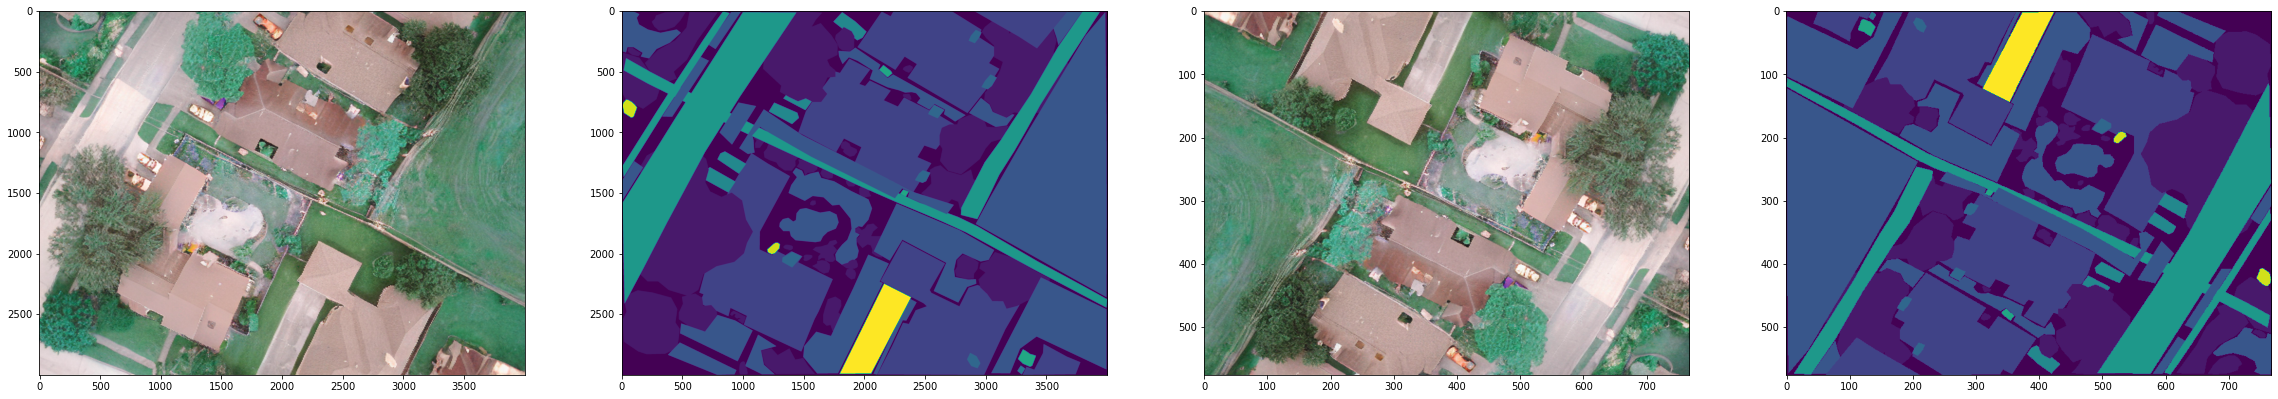

In [ ]:
origin_image, origin_mask, image, mask = train_dataset[np.random.randint(len(y_train))]   
figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(40, 20)) 
ax[0].imshow(origin_image)
ax[1].imshow(origin_mask)
ax[2].imshow(image)
ax[3].imshow(mask)

In [5]:
import segmentation_models_pytorch as smp
import torch
# model = smp.Unet('resnet50', encoder_weights=None, classes=27, in_channels=3 ,activation='softmax', encoder_depth=5, decoder_channels=[512,256,128,64,32]).to(DEVICE)
# model = smp.Unet('resnet101', encoder_weights='imagenet', classes=27, in_channels=3 ,activation=None, encoder_depth=5, decoder_channels=[1024, 512,256,128,64]).to(DEVICE)

DEVICE = 'cuda'
BATCH_SIZE=2

# model =  smp.UnetPlusPlus(
#                  encoder_name='resnet101',
#                  encoder_weights='imagenet',
#                 #  activation='sigmoid',
#                  in_channels=3,
#                  classes=27,
#                  encoder_depth=5, 
#                  decoder_channels=[1024, 512,256,128,64]
#           ).to(DEVICE)

model = torch.load('/content/drive/MyDrive/model1_49_57_1.326.pt')

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [20]:
max_lr = 1e-3
# epoch = 50
loss = torch.nn.CrossEntropyLoss()
weight_decay = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

max_score = 0
NUM_EPOCH = 200
hist_loss = []
for epoch in range(NUM_EPOCH): 
  print(f'=====================================Epoch: {epoch+1}')
  ret = train_one_epoch(model, train_loader, val_loader, optimizer, loss, epoch+1)
  hist_loss += [ret]
  if ret[1]+ret[3] > max_score:
    torch.save(model, f'/content/drive/MyDrive/transfer_checkpoints/model1_{round(ret[1]*100)}_{round(ret[3]*100)}_{round(ret[2], 3)}.pt')
    max_score = ret[1] + ret[3]
    print(f'Save model: model1_{round(ret[1]*100)}_{round(ret[3]*100)}_{round(ret[2], 3)}.pt')

=====================================Epoch: 1


  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

EPOCH: 2 - train loss: 1.3527244119380943 - train_accuracy: 0.5622276131570787 -  valid_loss: 1.1557344697770617 - val_accuracy: 0.6232432424286267
Save model: model1_56_62_1.156.pt
=====================================Epoch: 2


  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

EPOCH: 3 - train loss: 1.1832397043578438 - train_accuracy: 0.6119450014736365 -  valid_loss: 1.4170098764555794 - val_accuracy: 0.599752963703566
Save model: model1_61_60_1.417.pt
=====================================Epoch: 3


  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

EPOCH: 4 - train loss: 1.1044006314753474 - train_accuracy: 0.638938921206757 -  valid_loss: 1.132972883042835 - val_accuracy: 0.6295264188574737
Save model: model1_64_63_1.133.pt
=====================================Epoch: 4


  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

EPOCH: 5 - train loss: 1.042616562573773 - train_accuracy: 0.6569675314470476 -  valid_loss: 1.0595076992398216 - val_accuracy: 0.648269798642113
Save model: model1_66_65_1.06.pt
=====================================Epoch: 5


  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

EPOCH: 6 - train loss: 1.0284591177023648 - train_accuracy: 0.6650053076636478 -  valid_loss: 0.9976250347636995 - val_accuracy: 0.6790985161244767
Save model: model1_67_68_0.998.pt
=====================================Epoch: 6


  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

EPOCH: 7 - train loss: 0.9968598302762219 - train_accuracy: 0.6717580003521678 -  valid_loss: 1.0864142474674043 - val_accuracy: 0.6424888974144344
=====================================Epoch: 7


  0%|          | 0/942 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

EPOCH: 8 - train loss: 0.9579726237400322 - train_accuracy: 0.6855365452905531 -  valid_loss: 0.9421134378228869 - val_accuracy: 0.6854822660039129
Save model: model1_69_69_0.942.pt
=====================================Epoch: 8


  0%|          | 0/942 [00:00<?, ?it/s]

<ipython-input-10-14270efc24c4>:16: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'TiffImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  image = np.array(Image.open(self.image_paths[_id]))
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f8ecf05b900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 261, in __iter__
    yield obj
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 55542) is killed by signal: Segmentation fault. 


KeyboardInterrupt: ignored

In [21]:
train_accuries = []
val_accuries = []
train_losses = []
val_losses = []
for _t_loss, _t_acc, _v_loss, _v_acc in hist_loss:
  train_accuries += [_t_acc]
  val_accuries += [_v_acc]
  train_losses += [_t_loss]
  val_losses += [_v_loss]

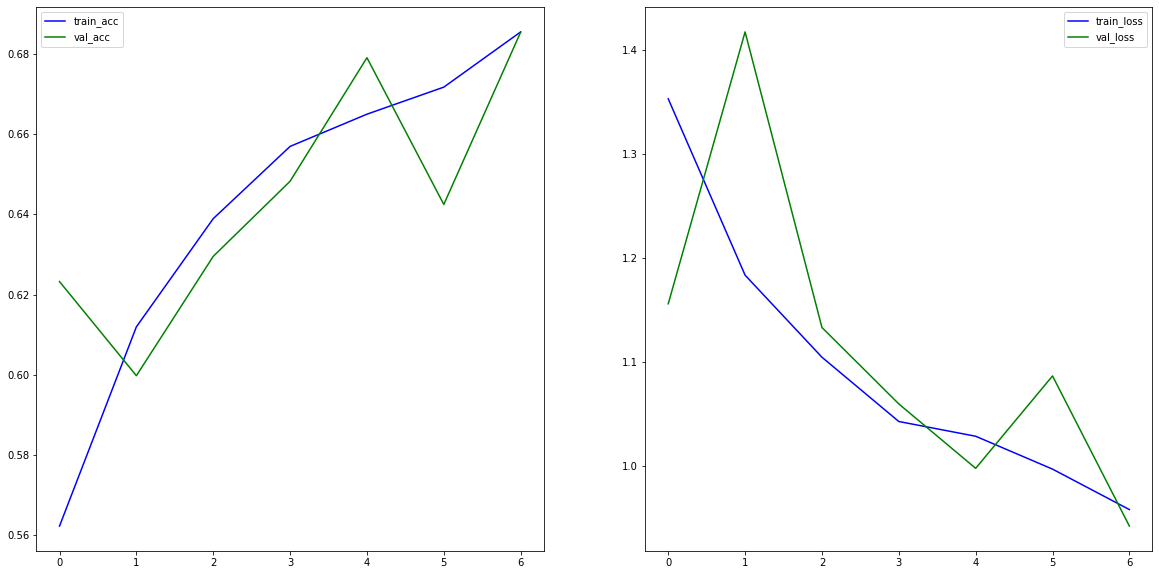

In [22]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 10)

ax[0].plot(train_accuries, 'b', label='train_acc')
ax[0].plot(val_accuries, 'g', label='val_acc')
ax[1].plot(train_losses, 'b', label='train_loss')
ax[1].plot(val_losses, 'g', label='val_loss')

ax[0].legend()
ax[1].legend()

fig.show()

In [ ]:
!rm results/*

rm: cannot remove 'results/*': No such file or directory


In [ ]:
# temp_model = torch.load('/content/model_34_88.pt')
temp_model = model
temp_model.eval()

with torch.no_grad():
  for _path in tqdm(test_image_paths):
    fname = os.path.basename(_path).replace('tif', 'png')
    image = np.array(Image.open(_path))
    origin_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = val_transform(image=origin_image)
    image = transformed["image"]
    h, w = origin_image.shape[:2]


    t = torch.unsqueeze(image, 0).to(DEVICE)
    output = temp_model(t)
    output = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1).detach().cpu().numpy()[0]

    output = cv2.resize(output, (w,h), interpolation=cv2.INTER_NEAREST)

    cv2.imwrite(f'results/{fname}', output)




  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
import tarfile
import os

tar = tarfile.open("submission.tar", "w")

for root, dir, files in os.walk('/content/results/'):
    for  file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()

In [ ]:
!cp submission.tar '/content/drive/MyDrive'

In [ ]:
len(os.listdir('results'))

75

In [ ]:
model.eval()
with torch.no_grad():
  t = torch.unsqueeze(image, 0).to(DEVICE)
  output = model(t)
  output = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1).detach().cpu().numpy()

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 20)) 
ax[0].imshow(cv2.resize(origin_image, (640,480)))
ax[1].imshow(output[0])

Train k-folder

In [ ]:
!rm ./*.pt

In [ ]:
# model = torch.load('/content/drive/MyDrive/temp_checkpoints/model_95_77.pt')

In [ ]:
train_transform = A.Compose(
    [
        # A.Resize(352, 352),
        A.Resize(576, 768),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(576, 768),
        # A.Resize(352, 352),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


In [ ]:
max_lr = 1e-3
# epoch = 50
weight_decay = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
loss = torch.nn.CrossEntropyLoss()

max_score = 0
NUM_EPOCH = 200
hist_loss = []
for epoch in range(NUM_EPOCH):
  print(f'=====================================Epoch: {epoch+1}')
  X_train, X_val, y_train, y_val = train_test_split(train_image_paths, train_mask_paths, test_size=0.2)

  train_dataset = HarveyDataset(X_train, y_train, transform=train_transform)
  val_dataset = HarveyDataset(X_val, y_val, transform=val_transform) 

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


  ret = train_one_epoch(model, train_loader, val_loader, optimizer, loss, epoch+1)
  hist_loss += [ret]
  if ret[1]+ret[3] > max_score:
    torch.save(model, f'/content/drive/MyDrive/temp1_checkpoints/model_{round(ret[1]*100)}_{round(ret[3]*100)}.pt')
    max_score = ret[1]+ret[3]
    print(f'Save model: model_{round(ret[1]*100)}_{round(ret[3]*100)}.pt')

  del train_dataset
  del val_dataset
  del train_loader
  del val_loader

=====================================Epoch: 1


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH: 2 - train loss: 0.582589310904344 - train_accuracy: 0.807151662567515 -  valid_loss: 0.5907502820094427 - val_accuracy: 0.8096605088975696
Save model: model_81_81.pt
=====================================Epoch: 2


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH: 3 - train loss: 0.5485292625923951 - train_accuracy: 0.8123384169590327 -  valid_loss: 0.5589054599404335 - val_accuracy: 0.8129668059172456
Save model: model_81_81.pt
=====================================Epoch: 3


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH: 4 - train loss: 0.5457137357443571 - train_accuracy: 0.8139720587082853 -  valid_loss: 0.6046180198589961 - val_accuracy: 0.7975062617549189
=====================================Epoch: 4


  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-9-14270efc24c4>:16: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'TiffImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  image = np.array(Image.open(self.image_paths[_id]))
<ipython-input-9-14270efc24c4>:17: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'PngImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  origin_mask = np.array(Image.open(self.mask_paths[_id]), dtype=np.int64)


KeyboardInterrupt: ignored

In [ ]:
train_accuries = []
val_accuries = []
train_losses = []
val_losses = []
for _t_loss, _t_acc, _v_loss, _v_acc in hist_loss:
  train_accuries += [_t_acc]
  val_accuries += [_v_acc]
  train_losses += [_t_loss]
  val_losses += [_v_loss]

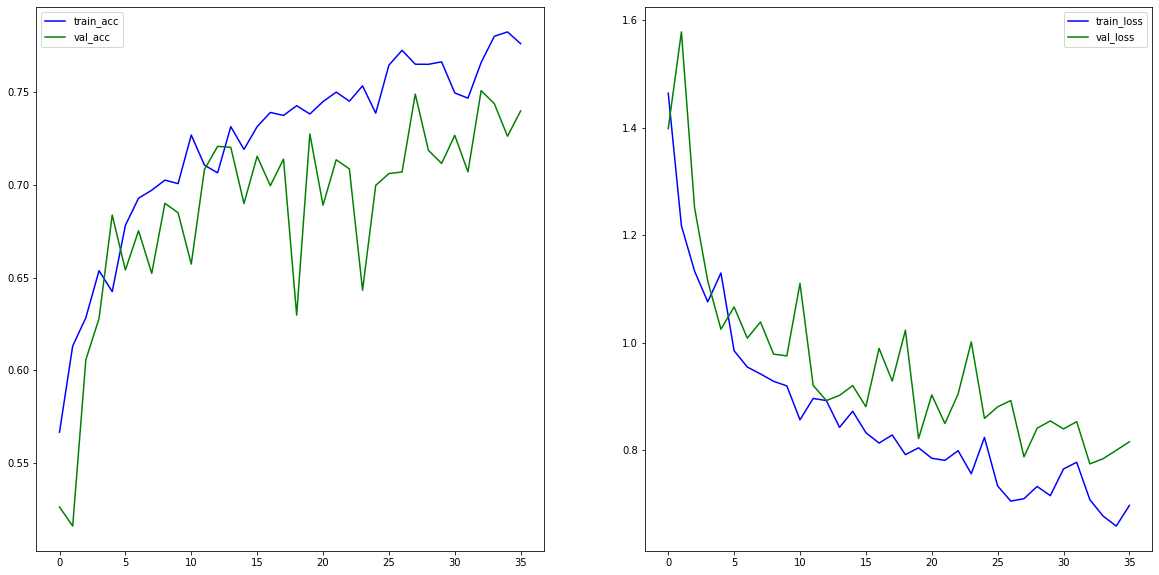

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 10)

ax[0].plot(train_accuries, 'b', label='train_acc')
ax[0].plot(val_accuries, 'g', label='val_acc')
ax[1].plot(train_losses, 'b', label='train_loss')
ax[1].plot(val_losses, 'g', label='val_loss')

ax[0].legend()
ax[1].legend()

fig.show()

### <hr>

###<hr>